In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
import matplotlib.pyplot as plt

<xarray.Dataset> Size: 2kB
Dimensions:      (depth_index: 15, doy: 12)
Coordinates:
  * depth_index  (depth_index) int64 120B 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * doy          (doy) float64 96B 15.0 45.0 75.0 105.0 ... 285.0 315.0 345.0
Data variables:
    temp_c       (depth_index, doy) float64 1kB ...

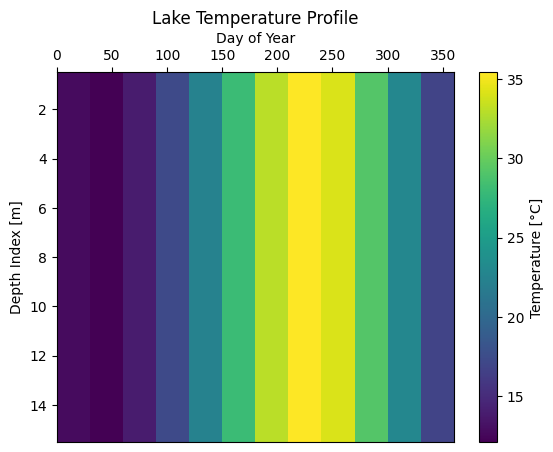

In [217]:
# Load lake data
lakedata =  xr.open_dataset('_test_prof.nc')

fig, prof = plt.subplots()
lakedata['temp_c'].plot()
prof.xaxis.set_label_position('top')
prof.invert_yaxis()
prof.xaxis.tick_top()
plt.title('Lake Temperature Profile')
plt.xlabel('Day of Year')
plt.ylabel('Depth Index [m]')
cbar = prof.collections[0].colorbar
cbar.set_label('Temperature [°C]')

lakedata

In [4]:
def clumped_sensor(temp_c, model):
        if model == 'I-CDES90':
            cap47 = 0.0004 * 10**6 / (temp_c + 273.15)**2 + 0.154 # Anderson et al 2021 I-CDES90 ref frame (w/ conversion from Celcius to Kelvin) # not including +/- uncertainties, can add later
        elif model == 'CDES90': 
            cap47 = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return cap47.to_numpy() # returns model eq back to caller (clumped_sensor)

In [47]:
#Inverse of clumped_sensor functions to return temperature from final clumped value
def clumped_temperature(cap47, model):
        if model == 'I-CDES90':
            temp_c =  ( (20 * (np.sqrt(cap47 - 0.154))) / (cap47 - 0.154) ) - 273.15
        elif model == 'CDES90': 
            temp_c = 1  # will add other functions
        else:
            raise ValueError('Model not recognized')
        
        return temp_c.to_numpy() # returns model eq back to caller (clumped_temperature)   

In [86]:
def generate_depth_weights(depth, weight_type): #add so that it adds weights to doy too based off notes (for loop?)
    """
    Generate a depth-weighting function.

    Args:
        depths (np.ndarray or pd.Series): Array or DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    if weight_type == 'uniform':
        weights = [1] * len(depth)  # Initialize all weights to 1
    
    elif weight_type == 'surface':
        weights = [0] * len(depth)  # Initialize all weights to 0
        weights[0] = 1  # Assign weight of 1 to the first element
        weights = pd.DataFrame(weights)
  
    elif weight_type == 'step':  # change depth_min and depth_max to desired depth values
        weights = np.where((depth >= 2) & (depth <= 4), 1, 0)  # Assign weight of 1 to depths within the range, 0 otherwise
        weights = pd.DataFrame(weights)
        
    elif weight_type == 'normal_dist':
        depth_index_mean = round(depth.values.mean(), 2)
        depth_index_std = round(depth.values.std(), 2)
        weights = (1 / (depth_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((depth - depth_index_mean) / depth_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

In [111]:
def generate_time_weights(timesteps, weight_type, selected_months=['January', 'February']): 
    """
    Generate a time-weighting function.

    Args:
        depths (pd.DataFrame): DataFrame column of depth values.
        weight_type (str): Equation type for computing the weighting with depth.
        selected_months (list): List of months to apply the 'range' weighting function to (e.g. selected_months=['January', 'February']), otherwise 'None'.

    Returns:
        np.ndarray: Array of weights aligned with the depth values.
    """
    months = {
        'MAMJ': range(60, 182),  # March to June
        'AMJ': range(91, 182),  # April to June  
        'AMJJ': range(91, 213),  # April to July
        'AMJJASO': range(91, 305),  # April to October
        'JJA': range(152, 244),  # July to August 
        'ASO': range(213, 305),  # August to October
        'January': range(0, 32),
        'February': range(32, 60),
        'March': range(60, 91),
        'April': range(91, 121),
        'May': range(121, 152),
        'June': range(152, 182),
        'July': range(182, 213),
        'August': range(213, 244),
        'September': range(244, 274),
        'October': range(274, 305),
        'November': range(305, 335),
        'December': range(335, 366)
        }
    
    if weight_type == 'uniform':
         weights = [1] * len(timesteps)  # Initialize all weights to 1
    
    elif weight_type == 'range':
       weights = np.zeros(len(timesteps))  # Initialize all weights to 0
       for month in selected_months: # Input selected month(s) into the selected months Arg (e.g. selected_months=['January', 'February']) 
        if month in months:
            for day in months[month]:
                if day < len(weights):
                    weights[day] = 1  # Apply weight of 1 to the selected days

    elif weight_type == 'normal_dist':
        time_index_mean = round(timesteps.values.mean(), 2)
        time_index_std = round(timesteps.values.std(), 2)
        weights = (1 / (time_index_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((timesteps - time_index_mean) / time_index_std) ** 2)
        # Normalize the weights so they sum to 1
        weights /= weights.sum()
    else:
        raise ValueError('Weight type not recognized')
    
    return weights

T47_c MAT: 23.168629629629816


<xarray.Dataset> Size: 3kB
Dimensions:                (doy: 12, depth_index: 15)
Coordinates:
  * doy                    (doy) float64 96B 15.0 45.0 75.0 ... 315.0 345.0
  * depth_index            (depth_index) int64 120B 1 2 3 4 5 ... 11 12 13 14 15
Data variables:
    temp_c_depth_wtd_mean  (doy) float64 96B 12.78 12.13 13.89 ... 22.9 16.8
    cap47_depth_wtd_mean   (doy) float64 96B 0.1589 0.1589 ... 0.1586 0.1588
    T47_c_depth_wtd_mean   (doy) float64 96B 12.78 12.13 13.89 ... 22.9 16.8
    time_weights           (doy) int64 96B 1 1 1 1 1 1 1 1 1 1 1 1
    cap47_time_wtd_mean    float64 8B 0.1586
    T47_c_MAT              float64 8B 23.17
    temp_c                 (depth_index, doy) float64 1kB ...
    depth_weights          (doy, depth_index) float64 1kB 0.02706 ... 0.02706

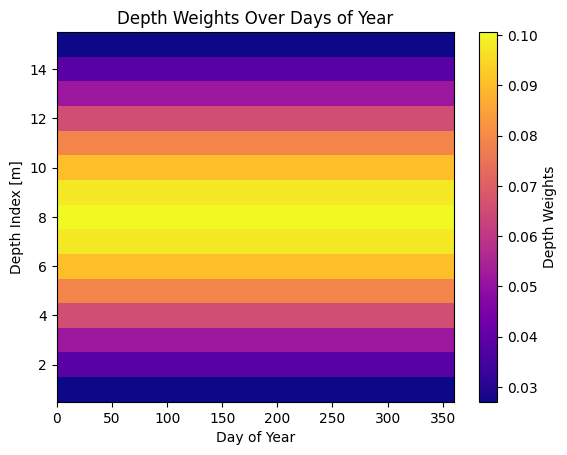

In [171]:
def process_lake_data(lakedata):
    timesteps = lakedata['doy'].values
    depth = pd.DataFrame(lakedata['depth_index'])
    cap47= []

    for ts in (timesteps) :
        tmpds = lakedata.sel(doy = ts) # pull out this timestep
        tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

        temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
        
        ts_cap47 = clumped_sensor(temp_c, 'I-CDES90')
        ts_cap47 = pd.DataFrame(ts_cap47).copy()
        ts_cap47 = ts_cap47.rename(columns={'temp_c': 'cap47'})
        cap47.append(ts_cap47)

        depth_weights = generate_depth_weights(depth, 'normal_dist')  
        
        if ts == timesteps[0]:
            df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            #df = df.assign(cap47 = ts_cap47.values)
            df = df.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean)
            df = df.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean)
        else:
            tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
            
            cap47_depth_wtd_mean = (ts_cap47.values * depth_weights).sum() / depth_weights.sum()
            temp_c_depth_wtd_mean = (temp_c * depth_weights).sum() / depth_weights.sum()
            #tdf = tdf.assign(cap47 = ts_cap47.values)
            tdf = tdf.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean)
            tdf = tdf.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean)
            df = pd.concat([tdf, df], ignore_index=True)
            df = df.dropna()      

    T47_c_depth_wtd_mean = clumped_temperature(df['cap47_depth_wtd_mean'], 'I-CDES90')

    df = df.set_index('doy', drop=True)
    df = df.assign(T47_c_depth_wtd_mean = T47_c_depth_wtd_mean)
    df = xr.Dataset.from_dataframe(df)
    time_weights = generate_time_weights(timesteps, 'uniform') 
    df = df.assign(time_weights=(['doy'], time_weights))
    df['cap47_time_wtd_mean'] = (df['cap47_depth_wtd_mean']* df['time_weights']).sum() / df['time_weights'].sum()
    df['T47_c_MAT'] = (df['T47_c_depth_wtd_mean'] * df['time_weights']).sum() / df['time_weights'].sum()

    depth_weights = depth_weights.rename(columns={0: 'depth_weights'}).values.flatten()

    final_output = xr.combine_by_coords([df, lakedata])

    final_output = final_output.assign(depth_weights=(['depth_index'], depth_weights))
    return final_output
#fig1 = df['cap47_wtd_mean']
#fig1.plot()
#cap47_arrays = [cap47.to_xarray() for cap47 in cap47]
#dataset = xr.concat(cap47_arrays, dim='doy')
#dataset = dataset.mean(dim='index')
#dataset = dataset.rename({0: 'cap47'})
#dataset = dataset.assign_coords(doy = timesteps)
#df = xr.concat([df, dataset], dim='doy')

final_output = process_lake_data(lakedata)
#final_output
depth_weights_expanded = np.tile(final_output['depth_weights'], (len(final_output['doy']), 1))
final_output["depth_weights"] = (['doy', 'depth_index'], depth_weights_expanded)
#final_output['depth_weights'].expand_dims(doy=final_output['doy'])


#Figure 1: Annual Depth Weighted Mean Cap47 Variability
Fig_1 = final_output['depth_weights'].transpose().plot(cmap='plasma')
plt.title('Depth Weights Over Days of Year')
plt.xlabel('Day of Year')
plt.ylabel('Depth Index [m]')
cbar = Fig_1.colorbar
cbar.set_label('Depth Weights')
print("T47_c MAT:", final_output['T47_c_MAT'].values)
final_output

Text(0, 0.5, 'T47 Depth Weighted Mean [°C]')

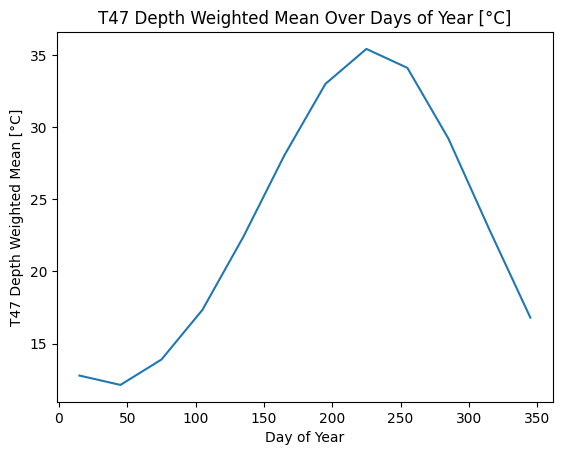

In [196]:
Fig_2 = final_output['T47_c_depth_wtd_mean'].plot()
plt.title('T47 Depth Weighted Mean Over Days of Year [°C]')
plt.xlabel('Day of Year')
plt.ylabel('T47 Depth Weighted Mean [°C]')

In [48]:
timesteps = lakedata['doy'].values
depth = pd.DataFrame(lakedata['depth_index'])

for ts in (timesteps) :
    tmpds = lakedata.sel(doy = ts) # pull out this timestep
    tmpdf = tmpds.to_dataframe().reset_index()  # convert it to pandas df

    temp_c = pd.DataFrame(tmpdf['temp_c'])['temp_c']
    temp_c_raw = pd.DataFrame(temp_c).copy()
    temp_c_raw = temp_c_raw.rename(columns={'temp_c':'temp_c_raw'})

    cap47 = clumped_sensor(temp_c_raw, 'I-CDES90')
    cap47_raw = pd.DataFrame(cap47).copy()
    cap47_raw = cap47_raw.rename(columns={'temp_c_raw':'cap47_raw'})

    depth_weights = generate_depth_weights(depth, 'surface')  
    depth_weights = pd.DataFrame(depth_weights, columns=['depth_weights'])
    
    if ts == timesteps[0]:
        df = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])
        cap47_depth_wtd_mean = (cap47_raw.values * depth_weights).sum() / depth_weights.sum()
       # cap47_depth_wtd_mean = pd.DataFrame(cap47_depth_wtd_mean)
       # cap47_depth_wtd_mean = cap47_depth_wtd_mean.rename(columns={'depth_weights':'cap47_depth_wtd_mean'})
        temp_c_depth_wtd_mean = (temp_c_raw * depth_weights).sum() / depth_weights.sum()
        df = df.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean)
        df = df.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean)
        df = df.join(temp_c_raw)
        df = df.join(cap47_raw)
        df = df.join(depth_weights)
        
    #else:
       #tdf = pd.DataFrame(tmpdf['doy'].values, columns=['doy'])

       #cap47_depth_wtd_mean = (cap47_raw.values * depth_weights).sum() / depth_weights.sum() 
       #temp_c_depth_wtd_mean = (temp_c_raw * depth_weights).sum() / depth_weights.sum()
       #tdf = tdf.assign(temp_c_depth_wtd_mean = temp_c_depth_wtd_mean)
       #tdf = tdf.assign(cap47_depth_wtd_mean = cap47_depth_wtd_mean)
       #tdf = tdf.join(temp_c_raw)
       #tdf = tdf.join(cap47_raw)
       #tdf = tdf.join(depth_weights)
       #df = pd.concat([tdf, df], ignore_index=True)
       #df = df.dropna()
       #df = df.dropna()      

df = df.set_index('doy', drop=True)
df = xr.Dataset.from_dataframe(df)
#df.drop(labels=['doy'], axis=1, inplace=True)

#df = df.assign(depth_weights=(['doy'], depth_weights))

#timesteps = df['doy']
time_weights = generate_time_weights(timesteps, 'uniform') 
#df = df.assign(time_weights=(['doy'], time_weights))
#T47_c = clumped_temperature(df['cap47_depth_wtd_mean'], 'I-CDES90')
#df = df.assign(T47_c=(['doy'], T47_c.data))

#df #= df.set_index('doy', drop=True)
df

<xarray.Dataset> Size: 720B
Dimensions:                (doy: 15)
Coordinates:
  * doy                    (doy) float64 120B 15.0 15.0 15.0 ... 15.0 15.0 15.0
Data variables:
    temp_c_depth_wtd_mean  (doy) float64 120B nan nan nan nan ... nan nan nan
    cap47_depth_wtd_mean   (doy) float64 120B nan nan nan nan ... nan nan nan
    temp_c_raw             (doy) float64 120B 12.78 12.78 12.78 ... 12.78 12.78
    0                      (doy) float64 120B 0.1589 0.1589 ... 0.1589 0.1589
    depth_weights          (doy) float64 120B nan nan nan nan ... nan nan nan